In [1]:
import pandas as pd
import csv as csv
import matplotlib.pyplot as plt
from config import gkey 
import gmaps

In [2]:
init_traffic_data = pd.read_csv("traffic_accidents.csv", low_memory=False)

In [3]:
#dropping unneeded columns
traffic_data = init_traffic_data.drop(labels=["GEO_X","GEO_Y","OBJECTID_1","INCIDENT_ID","OFFENSE_ID","LAST_OCCURENCE_DATE","REPORTED_DATE","OFFENSE_TYPE_ID","OFFENSE_CATEGORY_ID"],axis=1)

In [4]:
#renaming columns a *little* better
traffic_data.rename(columns={"FIRST_OCCURENCE_DATE":"ACCIDENT_DATE","GEO_LON":"LON","GEO_LAT":"LAT"},inplace=True)
traffic_data.head()

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,ACCIDENT_DATE,INCIDENT_ADDRESS,LON,LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,BICYCLE_IND,PEDESTRIAN_IND
0,5401,0,2012-11-02 18:20:00,1900 BLOCK S SHERIDAN BLVD,-105.052849,39.682112,4,421,Harvey Park,0,0
1,5441,0,2012-11-05 14:16:00,E HAMPDEN AVE / S YOSEMITE ST,-104.884786,39.653067,3,323,Hampden South,0,0
2,5401,0,2012-04-02 17:00:00,1300 BLOCK N BROADWAY ST,-104.986886,39.737147,6,623,Capitol Hill,0,0
3,5441,0,2012-06-11 17:05:00,600 BLOCK E EXPOSITION AVE,-104.979833,39.703898,3,311,Washington Park West,0,0
4,5441,0,2012-03-23 11:01:00,I25 HWYSB / W COLFAX AVE,-105.014162,39.740439,1,121,Lincoln Park,0,0


In [5]:
#splitting date&time stamp to usable columns
date_split = traffic_data["ACCIDENT_DATE"].str.split(" ",expand=True,n=1)
traffic_data["DATE"] = date_split[0]
traffic_data["TIME"] = date_split[1]
date_split = traffic_data["DATE"].str.split("-",expand=True,n=2)
traffic_data["YEAR"] = date_split[0]
traffic_data["MONTH"] = date_split[1]
traffic_data["DAY"] = date_split[2]
traffic_data.drop(labels=["ACCIDENT_DATE","DATE"],axis=1,inplace=True)
traffic_data['OVERALL_OFFENSE_CODE'] = traffic_data['OFFENSE_CODE'].map(str) + traffic_data['OFFENSE_CODE_EXTENSION'].map(str)

#dropping 2019 data as it's not a full year
traffic_data = traffic_data[traffic_data['YEAR'] != "2019"]

traffic_data.head()

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,INCIDENT_ADDRESS,LON,LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,BICYCLE_IND,PEDESTRIAN_IND,TIME,YEAR,MONTH,DAY,OVERALL_OFFENSE_CODE
0,5401,0,1900 BLOCK S SHERIDAN BLVD,-105.052849,39.682112,4,421,Harvey Park,0,0,18:20:00,2012,11,02,54010
1,5441,0,E HAMPDEN AVE / S YOSEMITE ST,-104.884786,39.653067,3,323,Hampden South,0,0,14:16:00,2012,11,05,54410
2,5401,0,1300 BLOCK N BROADWAY ST,-104.986886,39.737147,6,623,Capitol Hill,0,0,17:00:00,2012,04,02,54010
3,5441,0,600 BLOCK E EXPOSITION AVE,-104.979833,39.703898,3,311,Washington Park West,0,0,17:05:00,2012,06,11,54410
4,5441,0,I25 HWYSB / W COLFAX AVE,-105.014162,39.740439,1,121,Lincoln Park,0,0,11:01:00,2012,03,23,54410


In [6]:
#readding cleaned up offense descriptions, since they're way more useful than a code

descriptionlist = []
for eachcode in traffic_data['OVERALL_OFFENSE_CODE']:
    if eachcode == "54010":
        descriptionlist.append("Hit and Run")
    elif eachcode =="54200":
        descriptionlist.append("DUI")
    elif eachcode =="54410":
        descriptionlist.append("Routine Accident")
    elif eachcode =="54411":
        descriptionlist.append("Serious Bodily Injury")
    elif eachcode =="54412":
        descriptionlist.append("Fatal")
    elif eachcode =="54413":
        descriptionlist.append("Police")

traffic_data['OFFENSE_DESCRIPTION'] = descriptionlist

In [7]:
#reorder the dataframe, final usable dataframe
traffic_data = traffic_data[['OVERALL_OFFENSE_CODE','OFFENSE_DESCRIPTION','YEAR','MONTH',
                             'DAY','TIME','LAT','LON','INCIDENT_ADDRESS','DISTRICT_ID','PRECINCT_ID',
                             'NEIGHBORHOOD_ID','BICYCLE_IND','PEDESTRIAN_IND']]
traffic_data.head()

,OVERALL_OFFENSE_CODE,OFFENSE_DESCRIPTION,YEAR,MONTH,DAY,TIME,LAT,LON,INCIDENT_ADDRESS,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,BICYCLE_IND,PEDESTRIAN_IND
0,54010,Hit and Run,2012,11,02,18:20:00,39.682112,-105.052849,1900 BLOCK S SHERIDAN BLVD,4,421,Harvey Park,0,0
1,54410,Routine Accident,2012,11,05,14:16:00,39.653067,-104.884786,E HAMPDEN AVE / S YOSEMITE ST,3,323,Hampden South,0,0
2,54010,Hit and Run,2012,04,02,17:00:00,39.737147,-104.986886,1300 BLOCK N BROADWAY ST,6,623,Capitol Hill,0,0
3,54410,Routine Accident,2012,06,11,17:05:00,39.703898,-104.979833,600 BLOCK E EXPOSITION AVE,3,311,Washington Park West,0,0
4,54410,Routine Accident,2012,03,23,11:01:00,39.740439,-105.014162,I25 HWYSB / W COLFAX AVE,1,121,Lincoln Park,0,0


In [8]:
#group by year
traffic_data_groupby_year = traffic_data.groupby(by="YEAR")
traffic_data_groupby_year.count()

,OVERALL_OFFENSE_CODE,OFFENSE_DESCRIPTION,MONTH,DAY,TIME,LAT,LON,INCIDENT_ADDRESS,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,BICYCLE_IND,PEDESTRIAN_IND
YEAR,,,,,,,,,,,,,
2012,20560,20560,20560,20560,20560,20560,20560,20560,20560,20560,20560,20560,20560
2013,21182,21182,21182,21182,21182,21182,21182,21182,21182,21182,21182,21182,21182
2014,22444,22444,22444,22444,22444,22444,22444,22444,22444,22444,22444,22444,22444
2015,23842,23842,23842,23842,23842,23842,23842,23842,23842,23842,23842,23842,23842
2016,24254,24254,24254,24254,24254,24254,24254,24254,24254,24254,24254,24254,24254
2017,24617,24617,24617,24617,24617,24617,24617,24617,24617,24617,24617,24617,24617
2018,24905,24905,24905,24905,24905,24905,24905,24905,24905,24905,24905,24905,24905


In [9]:
#group by offense description
traffic_data_groupby_offense = traffic_data.groupby(by=["OFFENSE_DESCRIPTION"])
traffic_data_groupby_offense.count()

,OVERALL_OFFENSE_CODE,YEAR,MONTH,DAY,TIME,LAT,LON,INCIDENT_ADDRESS,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,BICYCLE_IND,PEDESTRIAN_IND
OFFENSE_DESCRIPTION,,,,,,,,,,,,,
DUI,5030,5030,5030,5030,5030,5030,5030,5030,5030,5030,5030,5030,5030
Fatal,331,331,331,331,331,331,331,331,331,331,331,331,331
Hit and Run,43112,43112,43112,43112,43112,43112,43112,43112,43112,43112,43112,43112,43112
Police,1570,1570,1570,1570,1570,1570,1570,1570,1570,1570,1570,1570,1570
Routine Accident,109538,109538,109538,109538,109538,109538,109538,109538,109538,109538,109538,109538,109538
Serious Bodily Injury,2223,2223,2223,2223,2223,2223,2223,2223,2223,2223,2223,2223,2223


In [10]:
#group by offense description THEN year
traffic_data_groupby_offenseandyear = traffic_data.groupby(by=["OFFENSE_DESCRIPTION","YEAR"])
traffic_data_groupby_offenseandyear.count()

OVERALL_OFFENSE_CODE  MONTH    DAY   TIME    LAT  \
OFFENSE_DESCRIPTION   YEAR                                                     
DUI                   2012                   707    707    707    707    707   
                      2013                   731    731    731    731    731   
                      2014                   815    815    815    815    815   
                      2015                   779    779    779    779    779   
                      2016                   692    692    692    692    692   
                      2017                   608    608    608    608    608   
                      2018                   698    698    698    698    698   
Fatal                 2012                    33     33     33     33     33   
                      2013                    43     43     43     43     43   
                      2014                    44     44     44     44     44   
                      2015                    54     54     54     54     54   
                      2016                    50     50     50     50     50   
                      2017                    48     48     48     48     48   
                      2018                    59     59     59     59     59   
Hit and Run           2012                  6129   6129   6129   6129   6129   
                      2013                  5359   5359   5359   5359   5359   
                      2014                  5577   5577   5577   5577   5577   
                      2015                  5933   5933   5933   5933   5933   
                      2016                  6444   6444   6444   6444   6444   
                      2017                  6809   6809   6809   6809   6809   
                      2018                  6861   6861   6861   6861   6861   
Police                2012                   173    173    173    173    173   
                      2013                   236    236    236    236    236   
                      2014                   186    186    186    186    186   
                      2015                   236    236    236    236    236   
                      2016                   238    238    238    238    238   
                      2017                   257    257    257    257    257   
                      2018                   244    244    244    244    244   
Routine Accident      2012                 13284  13284  13284  13284  13284   
                      2013                 14518  14518  14518  14518  14518   
                      2014                 15474  15474  15474  15474  15474   
                      2015                 16506  16506  16506  16506  16506   
                      2016                 16476  16476  16476  16476  16476   
                      2017                 16583  16583  16583  16583  16583   
                      2018                 16697  16697  16697  16697  16697   
Serious Bodily Injury 2012                   234    234    234    234    234   
                      2013                   295    295    295    295    295   
                      2014                   348    348    348    348    348   
                      2015                   334    334    334    334    334   
                      2016                   354    354    354    354    354   
                      2017                   312    312    312    312    312   
                      2018                   346    346    346    346    346   

                              LON  INCIDENT_ADDRESS  DISTRICT_ID  PRECINCT_ID  \
OFFENSE_DESCRIPTION   YEAR                                                      
DUI                   2012    707               707          707          707   
                      2013    731               731          731          731   
                      2014    815               815          815          815   
                      2015    779               779          779          779   
                     

In [11]:
#group by offense year THEN description
traffic_data_groupby_yearandoffense = traffic_data.groupby(by=["YEAR","OFFENSE_DESCRIPTION"])
traffic_data_groupby_yearandoffense.count()

OVERALL_OFFENSE_CODE  MONTH    DAY   TIME    LAT  \
YEAR OFFENSE_DESCRIPTION                                                       
2012 DUI                                     707    707    707    707    707   
     Fatal                                    33     33     33     33     33   
     Hit and Run                            6129   6129   6129   6129   6129   
     Police                                  173    173    173    173    173   
     Routine Accident                      13284  13284  13284  13284  13284   
     Serious Bodily Injury                   234    234    234    234    234   
2013 DUI                                     731    731    731    731    731   
     Fatal                                    43     43     43     43     43   
     Hit and Run                            5359   5359   5359   5359   5359   
     Police                                  236    236    236    236    236   
     Routine Accident                      14518  14518  14518  14518  14518   
     Serious Bodily Injury                   295    295    295    295    295   
2014 DUI                                     815    815    815    815    815   
     Fatal                                    44     44     44     44     44   
     Hit and Run                            5577   5577   5577   5577   5577   
     Police                                  186    186    186    186    186   
     Routine Accident                      15474  15474  15474  15474  15474   
     Serious Bodily Injury                   348    348    348    348    348   
2015 DUI                                     779    779    779    779    779   
     Fatal                                    54     54     54     54     54   
     Hit and Run                            5933   5933   5933   5933   5933   
     Police                                  236    236    236    236    236   
     Routine Accident                      16506  16506  16506  16506  16506   
     Serious Bodily Injury                   334    334    334    334    334   
2016 DUI                                     692    692    692    692    692   
     Fatal                                    50     50     50     50     50   
     Hit and Run                            6444   6444   6444   6444   6444   
     Police                                  238    238    238    238    238   
     Routine Accident                      16476  16476  16476  16476  16476   
     Serious Bodily Injury                   354    354    354    354    354   
2017 DUI                                     608    608    608    608    608   
     Fatal                                    48     48     48     48     48   
     Hit and Run                            6809   6809   6809   6809   6809   
     Police                                  257    257    257    257    257   
     Routine Accident                      16583  16583  16583  16583  16583   
     Serious Bodily Injury                   312    312    312    312    312   
2018 DUI                                     698    698    698    698    698   
     Fatal                                    59     59     59     59     59   
     Hit and Run                            6861   6861   6861   6861   6861   
     Police                                  244    244    244    244    244   
     Routine Accident                      16697  16697  16697  16697  16697   
     Serious Bodily Injury                   346    346    346    346    346   

                              LON  INCIDENT_ADDRESS  DISTRICT_ID  PRECINCT_ID  \
YEAR OFFENSE_DESCRIPTION                                                        
2012 DUI                      707               707          707          707   
     Fatal                     33                33           33           33   
     Hit and Run             6129              6129         6129         6129   
     Police                   173               173          173          173   
     Routine Accident

In [12]:
%matplotlib inline

In [13]:
#Stacked bar chart for all accidents for all years
unstacked_traffic_data = traffic_data_groupby_yearandoffense.count()['MONTH'].unstack()
unstacked_traffic_data

OFFENSE_DESCRIPTION,DUI,Fatal,Hit and Run,Police,Routine Accident,Serious Bodily Injury
YEAR,,,,,,
2012,707,33,6129,173,13284,234
2013,731,43,5359,236,14518,295
2014,815,44,5577,186,15474,348
2015,779,54,5933,236,16506,334
2016,692,50,6444,238,16476,354
2017,608,48,6809,257,16583,312
2018,698,59,6861,244,16697,346


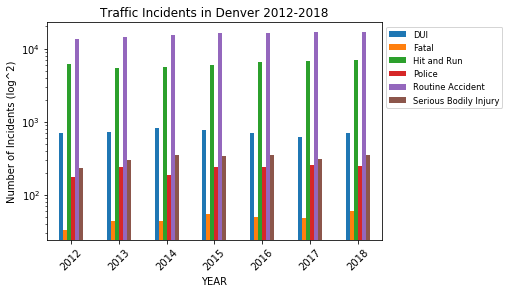

In [14]:
#I'm unable to adjust the figure size to be bigger unless I use notebook mode
unstacked_traffic_data.plot(kind='bar')
plt.title('Traffic Incidents in Denver 2012-2018')
plt.xticks(rotation=45)
plt.yscale('log')
plt.ylabel('Number of Incidents (log^2)')
plt.legend(loc='upper left', fontsize='small',  bbox_to_anchor=(1, 1))
plt.show()


In [15]:
plt.savefig('./Resources/cluttered_traffic_bar_chart.png')

<Figure size 432x288 with 0 Axes>

In [15]:
# traffic_data_morning_rush_hour = traffic_data[(traffic_data['TIME'] >= '05:00:00') & (traffic_data['TIME'] <= '09:00:00')]

# traffic_data_evening_rush_hour = traffic_data[(traffic_data['TIME'] >= '16:00:00') & (traffic_data['TIME'] <= '20:00:00')]

# traffic_data_midday = traffic_data[(traffic_data['TIME'] > '09:00:00') & (traffic_data['TIME'] < '16:00:00')]

# traffic_data_midday.head()

In [27]:
# #print(gkey)
# gmaps.configure(api_key=gkey)

# #no way to export map or save map as an image as a command (at least I can't find anything in the gmaps documentation)
# #so i can't just loop each year, i had to generate the map for each year individually.
# #also can't title in gmaps??
# fig_layout = {'width':'500px','height':'500px','border':'1px solid black'}
# locations = traffic_data[traffic_data['YEAR'] == "2017"][['LAT','LON']]
# fig = gmaps.figure(center=(39.72,-104.95), zoom_level=11,layout=fig_layout)
# fig.add_layer(gmaps.heatmap_layer(locations,point_radius=5,max_intensity=30))
# fig

In [28]:
#print(gkey)
# gmaps.configure(api_key=gkey)

# #no way to export map or save map as an image as a command (at least I can't find anything in the gmaps documentation)
# #so i can't just loop each year, i had to generate the map for each year individually.
# #also can't title in gmaps??

# locations = traffic_data_midday[['LAT','LON']]
# fig = gmaps.figure(center=(39.72,-104.95), zoom_level=11,layout=fig_layout)
# fig.add_layer(gmaps.heatmap_layer(locations,point_radius=5,max_intensity=30))
# fig

In [15]:
# print(traffic_data_midday.count())
# print(traffic_data_morning_rush_hour.count())
# print(traffic_data_evening_rush_hour.count())